In [436]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np

In [437]:
class Collector(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.random.seed(12345)
        self.id = unique_id

    def step(self) -> None:
        pass

In [438]:
class Explorer(Agent):
    RANDOM_SEED = 12345

    def __init__(self, unique_id: int, model: Model) -> None:
        """
        Initializes a new instance of the agent

        Args:
            unique_id (int): Unique identifier of the agent
            model (Model): Model in which the agent is instantiated
        """

        super().__init__(unique_id, model)
        self.random.seed(self.RANDOM_SEED)

    def move(self) -> None:
        """
        Moves the agent in the grid.
        """

        x, y = self.pos
        spiral_pattern = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2)]
        self.random.shuffle(spiral_pattern)

        for dx, dy in spiral_pattern:
            new_x, new_y = x + dx, y + dy

            if (
                0 <= new_x < self.model.grid.width
                and 0 <= new_y < self.model.grid.height
            ):
                self.model.grid.move_agent(self, (new_x, new_y))
                break

    def find_food(self) -> None:
        """
        Look for food in the grid.
        """

        x, y = self.pos
        if self.model.food_layer[x][y] > 0:
            self.model.known_food_layer[x][y] = 1

    def find_storage(self) -> None:
        """
        Look for storage in the grid.
        """

        x, y = self.pos
        if self.model.storage_location == (x, y):
            self.model.known_storage_location = (x, y)

    def step(self) -> None:
        """
        Step through the environment.
        """

        self.move()
        self.find_food()
        self.find_storage()

In [439]:
class NomNomModel(Model):
    RANDOM_SEED = 12345

    __slots__ = (
        "schedule",
        "grid",
        "running",
        "food_layer",
        "known_food_layer",
        "storage_location",
        "datacollector",
    )

    def __init__(self, width: int, height: int, num_agents=5, max_food=47) -> None:
        """
        Initializes the model with the given parameters.

        Args:
            width (int): The width of the grid.
            height (int): The height of the grid.
            num_agents (int): The number of agents to be created.
            max_food (int): The maximum amount of food to be created.
        """

        self.random.seed(self.RANDOM_SEED)

        # Data Collector
        self.datacollector = DataCollector(
            {
                "Food": lambda m: np.sum(m.food_layer),
                "Known Food": lambda m: np.sum(m.known_food_layer),
                "Agents": lambda m: m.schedule.get_agent_count(),
                "Warehouse location": lambda m: m.storage_location,
            }
        )

        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, False)
        self.running = True
        self.total_food_spawned = 0

        # Layers
        self.food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_storage_location = None
        self.num_food = max_food

        # Model Instances
        self.spawn_agents(3, Collector, "collector_")
        self.spawn_agents(2, Explorer, "explorer_")
        self.place_warehouse()

    def spawn_agents(
        self, num_agents: int, agent_class: Agent, prefix: str = ""
    ) -> None:
        """
        Spawns the agents in random places of the grid.

        Args:
            num_agents (int): The number of agents to be created.
            agent_class (Agent): The class of the agent to be created.
        """

        used_positions = set()

        for i, _ in enumerate(range(num_agents)):
            while True:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)

                if (x, y) not in used_positions:
                    agent = agent_class((prefix, i), self)
                    self.grid.place_agent(agent, (x, y))
                    self.schedule.add(agent)

                    used_positions.add((x, y))
                    break

    def spawn_food(self, max_food: int) -> None:
        """
        Spawns the food in random places of the grid between 2 to 5 cells with
        one food item. The interval between the spawns is 5 steps.

        Args:
            max_food (int): The maximum amount of food to be created.
        """

        num_food = self.random.randrange(2, 6)
        num_food = min(num_food, max_food - self.total_food_spawned)

        for _ in range(num_food):
            while True:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)

                if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0:
                    self.food_layer[x][y] = 1
                    self.total_food_spawned += 1
                    break

    def place_warehouse(self) -> None:
        """
        Places the warehouse in the center of the grid.
        """

        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0:
                self.storage_location = (x, y)
                break

    def step(self) -> None:
        """
        Advances the model by one step. Spawns the food each 5 steps
        """

        self.schedule.step()
        self.datacollector.collect(self)

        # Spawn food each 5 steps
        if self.schedule.steps % 5 == 0:
            self.spawn_food(self.num_food)

# Simulation Parameters

The simulation can be adjusted by changing the parameters in the cell below.

- **num_agents (int)**: The number of agents in the simulation.
- **max_food (int)**: The maximum amount of food that spawns in the simulation.
- **grid_size (int)**: The size of the grid in the simulation (grid_size x grid_size).
- **food_spawn_interval (int)**: The interval at which food spawns in the simulation.
- **min_food_per_spawn (int)**: The minimum amount of food that spawns in the simulation.
- **max_food_per_spawn (int)**: The maximum amount of food that spawns in the simulation.


In [440]:
NUM_AGENTS = 5
MAX_FOOD = 47
GRID_SIZE = 20

FOOD_SPAWN_INTERVAL = 5
MIN_FOOD_PER_SPAWN = 2
MAX_FOOD_PER_SPAWN = 5

In [441]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

def plot_simulation(model: NomNomModel, title: str, figsize=(10, 10), cmap="binary") -> None:
    """
    Plots the simulation grid.

    Args:
        model (NomNomModel): The model to be plotted.
        title (str): The title of the plot.
        figsize (tuple, optional): The size of the figure. Defaults to (10, 10).
        cmap (str, optional): The color map to be used. Defaults to "binary".
    """

    data = model.food_layer.copy()

    plt.figure(figsize=figsize)
    heatmap = plt.imshow(data, cmap=cmap)

    # Warehouse location
    warehouse_x, warehouse_y = model.storage_location
    plt.scatter(warehouse_y, warehouse_x, color="black", marker="s", s=50, label="Warehouse")


    for i in range(len(model.food_layer)):
        for j in range(len(model.food_layer[0])):
            box_color = "white" if model.food_layer[i][j] > 0 else "black"

            plt.text(j, i, model.food_layer[i][j], ha="center", va="center", color=box_color)

    plt.colorbar(heatmap)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", bbox_to_anchor=(1, 1), fontsize=12)
    plt.xlabel("aisle", fontsize=14)
    plt.ylabel("shelf", fontsize=14)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    plt.show()

In step 0 how many food items are in the grid? 0
In step 1 how many food items are in the grid? 0
In step 2 how many food items are in the grid? 0
In step 3 how many food items are in the grid? 0
In step 4 how many food items are in the grid? 0
In step 5 how many food items are in the grid? 3
In step 6 how many food items are in the grid? 3
In step 7 how many food items are in the grid? 3
In step 8 how many food items are in the grid? 3
In step 9 how many food items are in the grid? 3
In step 10 how many food items are in the grid? 8
In step 11 how many food items are in the grid? 8
In step 12 how many food items are in the grid? 8
In step 13 how many food items are in the grid? 8
In step 14 how many food items are in the grid? 8
In step 15 how many food items are in the grid? 11
In step 16 how many food items are in the grid? 11
In step 17 how many food items are in the grid? 11
In step 18 how many food items are in the grid? 11
In step 19 how many food items are in the grid? 11
In st

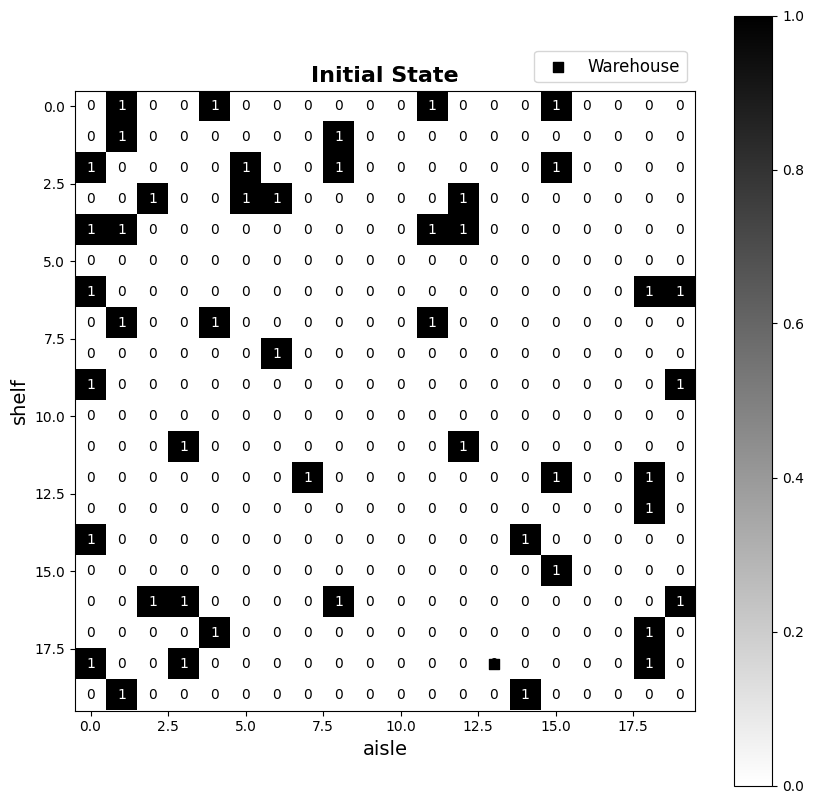

    Food  Known Food  Agents Warehouse location
0      0           0       5           (18, 13)
1      0           0       5           (18, 13)
2      0           0       5           (18, 13)
3      0           0       5           (18, 13)
4      0           0       5           (18, 13)
..   ...         ...     ...                ...
76    47           2       5           (18, 13)
77    47           2       5           (18, 13)
78    47           2       5           (18, 13)
79    47           2       5           (18, 13)
80    47           2       5           (18, 13)

[81 rows x 4 columns]


In [442]:
def run_simulation() -> Model:
    """
    Runs the simulation.
    """

    model = NomNomModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, MAX_FOOD)

    for _ in range(81):
        print(
            f"In step {model.schedule.steps} how many food items are in the grid? {np.sum(model.food_layer)}"
        )
        model.step()

    plot_simulation(model, "Initial State")
    return model


model = run_simulation()

print(model.datacollector.get_model_vars_dataframe())